In [8]:
from collections import defaultdict
import json
from glob import glob
from typing import Tuple

from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
from numpy import exp
import pandas as pd
from scipy.signal import find_peaks

from utils import dict_sum, as_series, as_dataframe, to_cumulative

mpl.rcParams['lines.linewidth'] = 2.5

# Base line variant distribution

In [2]:
def json_counts_to_dataframe() -> Tuple[pd.DataFrame, pd.DataFrame]:
    normal_counts = defaultdict(lambda: defaultdict(int))
    variant_counts = defaultdict(lambda: defaultdict(int))
    max_fragment_size = 1
    for json_file in glob('output/*.json'):
        with open(json_file) as file_object:
            fragments = json.load(file_object)
            for var in fragments['variants']:
                counts = var["fragment_size_counts"]
                normal_base = var["nucleotide_normal"]
                gene = var['gene']
                normal_counts[gene] = dict_sum(normal_counts[gene], counts[normal_base])
                for base in var['nucleotide_variants']:
                    variant_counts[gene] = dict_sum(variant_counts[gene], counts[base])
            max_fragment_size = max(max(normal_counts[gene].keys()), max(variant_counts[gene].keys()), max_fragment_size)

    normals = as_dataframe(normal_counts, max_fragment_size)
    variants = as_dataframe(variant_counts, max_fragment_size)
    return normals, variants

In [3]:
normals, variants = json_counts_to_dataframe()

In [4]:
def kolmogorov_smirnov(normal_counts, variant_counts):
    m = sum(normal_counts)
    n = sum(variant_counts)
    D = max(to_cumulative(normal_counts) - to_cumulative(variant_counts))
    r = (n + m)/(n*m)
    alpha = 2 * exp(- 2 * D**2 /r) 
    return alpha

In [5]:
def plot_distribution_comparison(normal_counts, variant_counts, filename_suffix = None):
    normal_distribution = normal_counts / sum(normal_counts)
    normal_cumul = normal_distribution.cumsum()
    variant_distribution = variant_counts / sum(variant_counts)
    variant_cumul = variant_distribution.cumsum()
    
    fragment_window = [50, 500]
    
    normal_distribution.plot(label='normal')
    variant_distribution.plot(label='variant')
    plt.legend(frameon=False)
    plt.xlim(fragment_window)
    p = kolmogorov_smirnov(normal_counts, variant_counts)
    plt.annotate('$p$ = {:.1E}'.format(p), xy=(300, 0.015))
    plt.xlabel('Fragment size (bp)')
    plt.ylabel('Frequency')
    if filename_suffix is not None:
        plt.savefig(f'figs/fragment_size_distribution_{filename_suffix}.png')
    
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(normal_cumul, label='normal')
    plt.plot(variant_cumul, label='variant')
    plt.ylabel('Cumulative distribution')
    plt.xlabel('Fragment size (bp)')
    plt.xlim(fragment_window)
    
    plt.subplot(1, 2, 2)
    plt.plot(normal_cumul-variant_cumul)
    plt.xlabel('Fragment size (bp)')
    plt.ylabel('Kolmogorov-Smirnov distance')
    plt.xlabel('Fragment size (bp)')
    plt.xlim(fragment_window)
    plt.tight_layout()
    if filename_suffix is not None:
        plt.savefig(f'figs/fragment_size_distribution_difference_{filename_suffix}.png')

In [156]:
def plot_distribution_with_peaks(seq):
    n = 5
    peak_constaints = {'width': 15, 'distance': 50, 'rel_height': 0.75}    
    seq /= sum(seq)
    peaks, properties = find_peaks(seq.rolling(n).mean(), **peak_constaints)
    print(peaks)
    print(properties['widths'])
    
    fragment_window = [50, 500]
    plt.xlim(fragment_window)
    seq.rolling(n).mean().plot()
    plt.plot(peaks, seq[peaks], 'o')
    plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
               xmax=properties["right_ips"], color = "C1")

[167 314 477]
[48.76235683 79.21903794 69.34621212]
[167 298 527]
[82.4047619 16.75      16.       ]


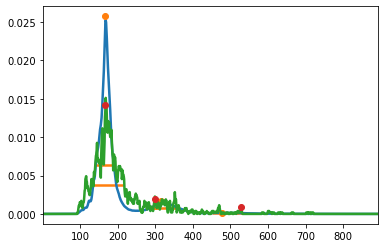

In [157]:
plot_distribution_with_peaks(normals.sum(axis=1))
plot_distribution_with_peaks(variants['TERT'])

In [158]:
def compare_peak_shifts(variant_distribution, reference_distribution):
    n = 5
    peak_constaints = {'width': 15, 'distance': 100, 'rel_height': 0.75}
    ref_peaks, ref_properties = find_peaks(reference_distribution.rolling(n).mean(), **peak_constaints)
    
    def peak_shift(sequence, num_peaks=2):
        peaks, props = find_peaks(sequence.rolling(n).mean(), **peak_constaints)
        max_peaks = min(num_peaks, len(peaks), len(ref_peaks))
       
        s1 = pd.Series({
            f'{peak_number+1}_shift': peaks[peak_number] - ref_peaks[peak_number]
            for peak_number in range(max_peaks)
        })
        print(s1.index)
        s2 = pd.Series({
            f'{peak_number+1}_broadening': props['widths'][peak_number] - ref_properties['widths'][peak_number]
            for peak_number in range(max_peaks)
        })
        return pd.concat([s1,s2])

    significant_columns = tuple(
        c 
        for c in variant_distribution.columns 
        if kolmogorov_smirnov(reference_distribution, variant_distribution[c]) < 0.05
    )
    data_frame = pd.DataFrame(columns=significant_columns)
    for c in significant_columns:
        print(c)
        data_frame[c] = peak_shift(variant_distribution[c])
#         data_frame.loc['mean_shift', c] = (variant_distribution[c].mean() - reference_distribution.mean())/reference_distribution.mean()
    return data_frame
#     peak1 = pd.DataFrame({
#         c: peak_shift(variant_distribution[c], peak_number=0) for c in variant_distribution.columns
#     })
#     peak2 = pd.DataFrame({
#         c: peak_shift(variant_distribution[c], peak_number=1) for c in variant_distribution.columns
#     })
#     return pd.concat([peak1, peak2])

APC
Index(['1_shift', '2_shift'], dtype='object')
AR
Index(['1_shift', '2_shift'], dtype='object')
BRAF
Index(['1_shift', '2_shift'], dtype='object')
CDK4
Index(['1_shift', '2_shift'], dtype='object')
CDKN2A
Index(['1_shift', '2_shift'], dtype='object')
CTNNB1
Index(['1_shift', '2_shift'], dtype='object')
FLT1
Index(['1_shift', '2_shift'], dtype='object')
IDH1
Index(['1_shift', '2_shift'], dtype='object')
KEAP1
Index(['1_shift', '2_shift'], dtype='object')
KRAS
Index(['1_shift', '2_shift'], dtype='object')
MSH2
Index(['1_shift', '2_shift'], dtype='object')
NFE2L2
Index(['1_shift', '2_shift'], dtype='object')
PDGFRB
Index(['1_shift', '2_shift'], dtype='object')
PMS2
Index(['1_shift', '2_shift'], dtype='object')
RNF43
Index(['1_shift', '2_shift'], dtype='object')
SMO
Index(['1_shift', '2_shift'], dtype='object')
STK11
Index(['1_shift', '2_shift'], dtype='object')
TP53
Index(['1_shift', '2_shift'], dtype='object')


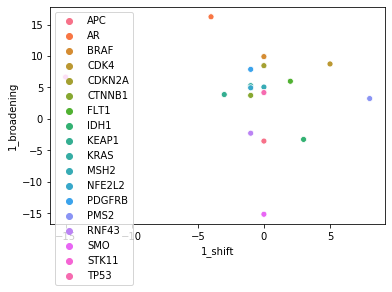

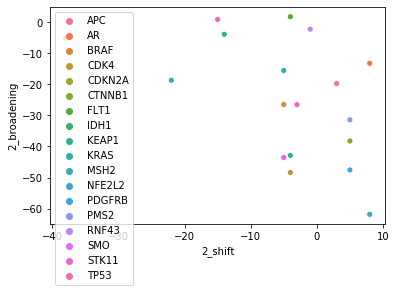

In [161]:
import seaborn as sns
df = compare_peak_shifts(variants, normals.sum(axis=1)).T
sns.scatterplot(
    x='1_shift', 
    y='1_broadening', 
    hue=df.index,
    data=df,
)
plt.figure()
sns.scatterplot(
    x='2_shift', 
    y='2_broadening', 
    hue=df.index,
    data=df,
)

In [ ]:
variants.columns

In [ ]:
plt.figure(figsize=(3, 3))
from scipy.signal import find_peaks

seq = variants.sum(axis=1)
n = 5
peaks, properties = find_peaks(seq.rolling(n).mean(), width=15, distance=100)
print(peaks)
print(properties['widths'])
seq.plot()
seq.rolling(n).mean().plot()
fragment_window = [50, 500]
plt.xlim(fragment_window)
plt.plot(peaks, seq[peaks], 'o')
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color = "C1")

In [ ]:
plot_distribution_comparison(normals.sum(axis=1), variants.sum(axis=1), filename_suffix='all')

In [ ]:
for gene in normals.columns:
    f = plt.figure(figsize=(8,3))
    plt.title(gene)
    plot_distribution_comparison(normals[gene], variants[gene])

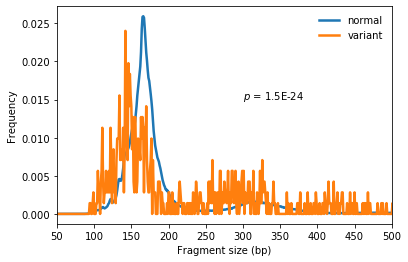

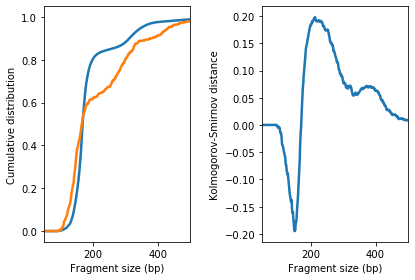

In [134]:
plot_distribution_comparison(normals.sum(axis=1), variants['ABL1'], filename_suffix='EGFR')

In [ ]:
plot_distribution_comparison(normals.sum(axis=1), normals['EGFR'], filename_suffix='EGFR')